In [46]:
import pandas as pd
import random
#Visualisation Library
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#Classification model 
from sklearn.linear_model import LogisticRegression

#Classification model evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

#To split the model into training and testing data
from sklearn.model_selection import train_test_split

#Different model improvement packages
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import torch
from torch import nn
from tqdm import tqdm


#Evaluation metrics
from sklearn import metrics

import joblib

In [47]:
logistic = pd.read_csv('LogisticRegression.csv')
dt = pd.read_csv('DecisionTreeClassifier.csv')
rf = pd.read_csv('RandomForestClassifier.csv')
xgb = pd.read_csv('XGBClassifier.csv')

In [48]:
logistic.head()

,Unnamed: 0,Loan_ID,Loan_Status,Gender,Race
0,0,LP001015,1,Male,Black
1,1,LP001022,1,Male,Black
2,2,LP001031,1,Male,Black
3,3,LP001051,1,Male,Black
4,4,LP001054,1,Male,Black


In [49]:
races = logistic.Race.unique()
genders = logistic.Gender.unique()
races, genders

(array(['Black', 'White'], dtype=object),
 array(['Male', 'Female'], dtype=object))

In [50]:
logistic['Loan_Status'].value_counts()

Loan_Status
1    348
0     19
Name: count, dtype: int64

### Demographic parity

In [51]:
def demo_parity(df: pd.DataFrame, col: str, val: str):
    total_num = len(df[df[col] == val])
    predict_true = len(df[(df['Loan_Status'] == 1) & (df[col] == val)])
    return predict_true/total_num

In [52]:
class Model:
    def __init__(self, name: str):
        self.name = name
        self.gender_ratio = 0
        self.race_ratio = 0
        self.fair_score = 0

    def __str__(self):
        return f"Model('{self.name}', fair_score={self.fair_score})"


In [53]:
model_list = [Model('Logistic'), Model('DecisionTree'), Model('RandomForest'), Model('XGB')]

In [54]:
def show_bias(df: pd.DataFrame, model: Model):
    demo_dict = {}
    print('Gender: ')
    for g in genders:
        demo_dict[g] = demo_parity(df, 'Gender', g)
        print(g, demo_dict[g])

    difference = abs(demo_dict["Male"] - demo_dict["Female"])
    ratio = demo_dict["Male"]/demo_dict["Female"] if demo_dict["Female"] != 0 else 0
    ratio = ratio if ratio < 1 else 1/ratio
    model.gender_ratio = ratio
    print('Difference: ', difference)
    print('Ratio: ', ratio)

    print()
    demo_dict = {}
    print('Race: ')
    for r in races:
        demo_dict[r] = demo_parity(df, 'Race', r)
        print(r, demo_dict[r])

    difference = abs(demo_dict["White"] - demo_dict["Black"])
    ratio = demo_dict["White"]/demo_dict["Black"] if demo_dict["Black"] != 0 else 0
    ratio = ratio if ratio < 1 else 1/ratio
    model.race_ratio = ratio
    print('Difference: ', difference)
    print('Ratio: ', ratio)

### Base Model: Logistic Regression

In [55]:
show_bias(logistic, model_list[0])

Gender: 
Male 0.9595959595959596
Female 0.9
Difference:  0.059595959595959536
Ratio:  0.9378947368421052

Race: 
Black 0.9760479041916168
White 0.925
Difference:  0.051047904191616755
Ratio:  0.9476993865030675


In [56]:
show_bias(dt, model_list[1])

Gender: 
Male 0.6094276094276094
Female 0.5857142857142857
Difference:  0.023713323713323686
Ratio:  0.9610891870560379

Race: 
Black 0.688622754491018
White 0.535
Difference:  0.15362275449101792
Ratio:  0.776913043478261


In [57]:
show_bias(rf, model_list[2])

Gender: 
Male 0.7676767676767676
Female 0.6428571428571429
Difference:  0.12481962481962472
Ratio:  0.837406015037594

Race: 
Black 0.8143712574850299
White 0.685
Difference:  0.12937125748502987
Ratio:  0.841139705882353


In [58]:
show_bias(xgb, model_list[3])

Gender: 
Male 0.6868686868686869
Female 0.6571428571428571
Difference:  0.02972582972582971
Ratio:  0.9567226890756302

Race: 
Black 0.7544910179640718
White 0.62
Difference:  0.1344910179640718
Ratio:  0.8217460317460318


#### Gender

In [59]:
model_list = sorted(model_list, key=lambda x: x.gender_ratio)
for model in model_list:
    print(model)

Model('RandomForest', fair_score=0)
Model('Logistic', fair_score=0)
Model('XGB', fair_score=0)
Model('DecisionTree', fair_score=0)


#### Race

In [60]:
model_list = sorted(model_list, key=lambda x: x.race_ratio)
for model in model_list:
    print(model)

Model('DecisionTree', fair_score=0)
Model('XGB', fair_score=0)
Model('RandomForest', fair_score=0)
Model('Logistic', fair_score=0)


Here we use the average of `Race` and `Gender` demographic parity ratio as the bias score. The higher the score, the less biased the model is. 

In [61]:
for model in model_list:
    model.fair_score = (model.gender_ratio + model.race_ratio) / 2

In [62]:
model_list = sorted(model_list, key=lambda x: x.fair_score)
for model in model_list:
    print(model)

Model('RandomForest', fair_score=0.8392728604599735)
Model('DecisionTree', fair_score=0.8690011152671494)
Model('XGB', fair_score=0.889234360410831)
Model('Logistic', fair_score=0.9427970616725864)


Logistic regression performs best in the demographic parity test.

# Mitigating Bias

## 1. expand dataset

In [64]:
tr = pd.read_csv('./data/cleaned_train.csv')

In [65]:
old = len(tr)
old

591

In [66]:
tr.Race.value_counts()

Race
Black    496
White     95
Name: count, dtype: int64

In [67]:
tr.Gender.value_counts()

Gender
Male      482
Female    109
Name: count, dtype: int64

In [68]:
tr.isnull().sum()

Loan_ID              0
Gender               0
Race                 0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

The data is biased towards `Black` and `Male`. For all rows, generate 3 new rows with different `Race` and `Gender` values.

In [69]:
exp_data = pd.DataFrame(columns=tr.columns)
for _, row in tr.iterrows():
    for race in ['Black', 'White']:
        for gender in ['Male', 'Female']:
            if row['Race'] != race or row['Gender'] != gender:
                new_row = row.copy()
                new_row['Race'] = race
                new_row['Gender'] = gender
                new_row_df = pd.DataFrame([new_row])
                exp_data = pd.concat([exp_data, new_row_df])

In [70]:
len(exp_data), len(tr) * 3

(1773, 1773)

In [71]:
exp_data.isnull().sum()

Loan_ID              0
Gender               0
Race                 0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [72]:
tr = pd.concat([tr,exp_data])

In [73]:
tr.to_csv('expanded_train.csv', index=False)

In [74]:
len(tr)

2364

Expand data

<Axes: xlabel='Gender'>

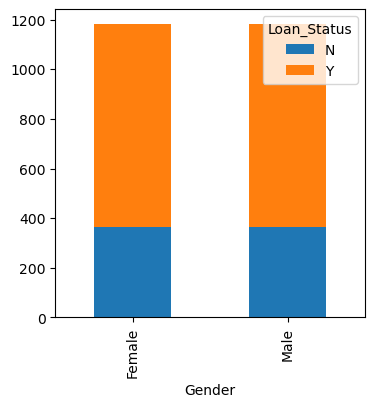

In [75]:
gender=pd.crosstab(tr['Gender'],tr['Loan_Status'])
gender.plot(kind='bar',stacked=True,figsize=(4,4))

<Axes: xlabel='Race'>

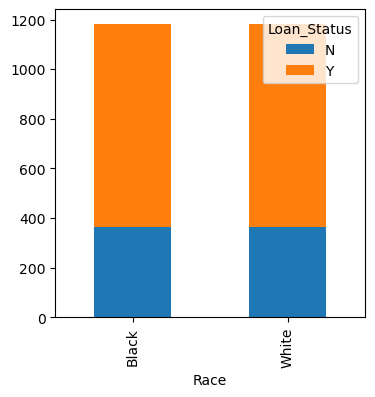

In [ ]:
gender=pd.crosstab(tr['Race'],tr['Loan_Status'])
gender.plot(kind='bar',stacked=True,figsize=(4,4))

In [ ]:
tr['Gender'].value_counts()

Gender
Male      1182
Female    1182
Name: count, dtype: int64

In [ ]:
tr['Race'].value_counts()

Race
Black    1182
White    1182
Name: count, dtype: int64

# Retrain Model

In [ ]:
tr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2364 entries, 0 to 590
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            2364 non-null   object 
 1   Gender             2364 non-null   object 
 2   Race               2364 non-null   object 
 3   Married            2364 non-null   object 
 4   Dependents         2364 non-null   object 
 5   Education          2364 non-null   object 
 6   Self_Employed      2364 non-null   object 
 7   ApplicantIncome    2364 non-null   object 
 8   CoapplicantIncome  2364 non-null   float64
 9   LoanAmount         2364 non-null   float64
 10  Loan_Amount_Term   2364 non-null   float64
 11  Credit_History     2364 non-null   float64
 12  Property_Area      2364 non-null   object 
 13  Loan_Status        2364 non-null   object 
dtypes: float64(4), object(10)
memory usage: 277.0+ KB


In [ ]:
#Converting dependents into int as it includes integer values
tr['Dependents']=tr['Dependents'].astype('int')
tr['ApplicantIncome'] = tr['ApplicantIncome'].astype('int')
#Mapping the object columns to convert it into binary from and then change the data type to int
tr['Married']=tr['Married'].map({'Yes':1, 'No':0})
tr['Education']=tr['Education'].map({'Graduate':1, 'Not Graduate':0})
tr['Self_Employed']=tr['Self_Employed'].map({'Yes':1, 'No':0})
tr['Loan_Status']=tr['Loan_Status'].map({'Y':1, 'N':0})

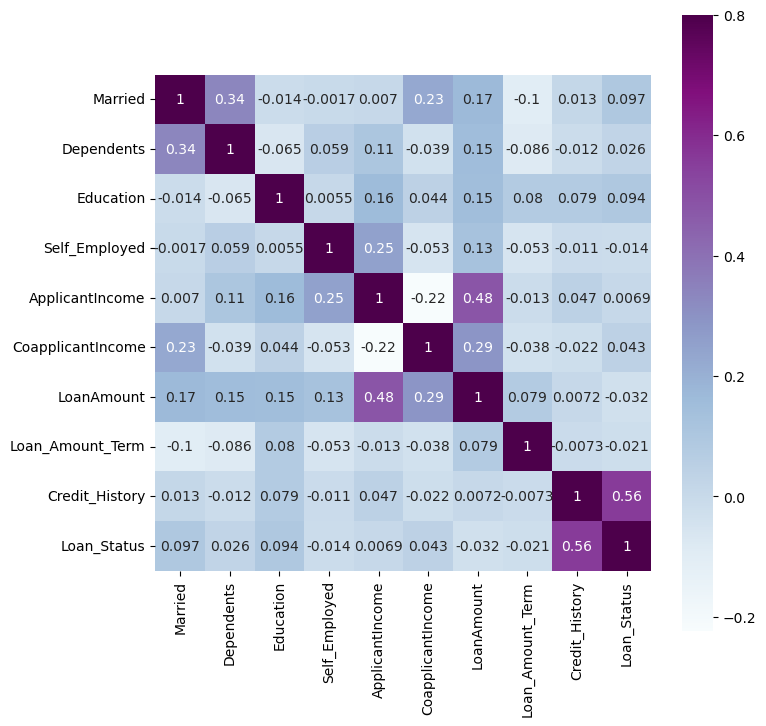

In [ ]:
# Specify numeric columns
numeric_columns = tr.select_dtypes(include=[np.number])

# Calculate correlation matrix
matrix = numeric_columns.corr()

# Plot heatmap
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(matrix, vmax=0.8, square=True, cmap="BuPu", annot=True)
plt.show()


In [ ]:
tr.columns

Index(['Loan_ID', 'Gender', 'Race', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [ ]:
len(tr)

2364

In [ ]:

tr.drop('Loan_ID',axis=1, inplace=True)
#Using get dummies for the remaining object columns for which mapping or encoder cant be used 
tr=pd.get_dummies(tr)
tr.head()


,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Female,Gender_Male,Race_Black,Race_White,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,0,0,1,0,5849,0.0,146.41,360.0,1.0,1,False,True,True,False,False,False,True
1,1,1,1,0,4583,1508.0,128.00,360.0,1.0,0,False,True,True,False,True,False,False
2,1,0,1,1,3000,0.0,66.00,360.0,1.0,1,False,True,True,False,False,False,True
3,1,0,0,0,2583,2358.0,120.00,360.0,1.0,1,False,True,True,False,False,False,True
4,0,0,1,0,6000,0.0,141.00,360.0,1.0,1,False,True,True,False,False,False,True


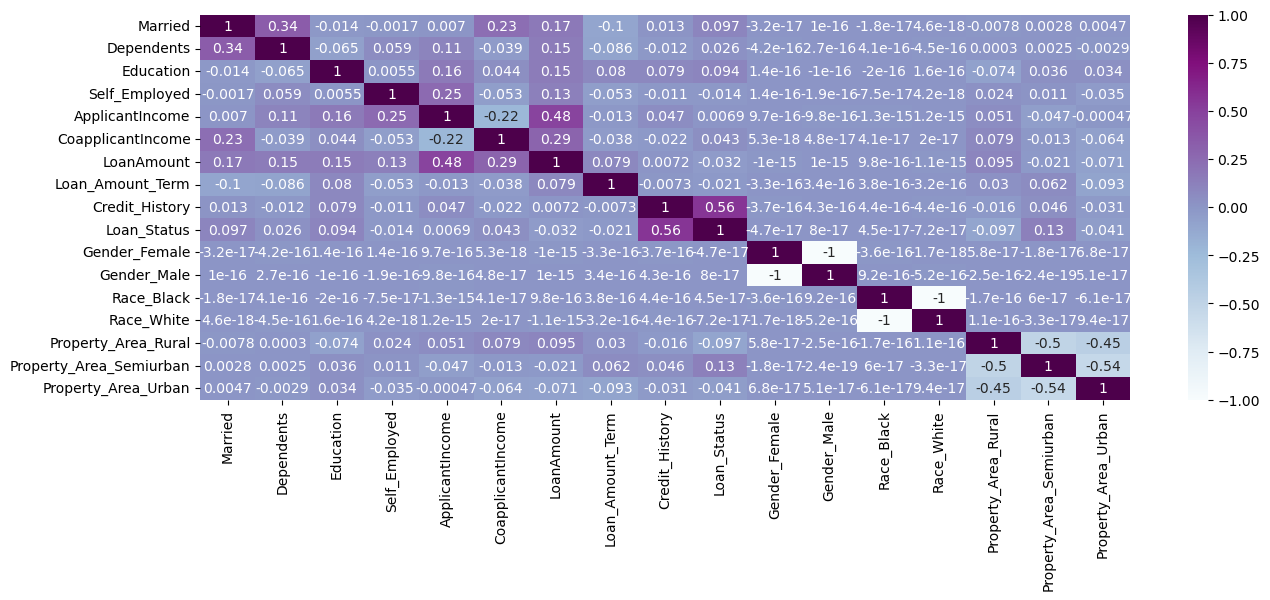

In [ ]:
#Checking for correlation again now that we have treated the object columns
plt.figure(figsize=(15,5))
sns.heatmap(tr.corr(),cmap='BuPu',annot=True)
plt.show()

In [ ]:
#Spliting the dataset into features and target
x=tr.drop('Loan_Status',axis=1)
y=tr['Loan_Status']
#Further splitting the dataset into training and testing data
xtrain,xtest,ytrain,ytest= train_test_split(x,y,test_size=0.25,stratify=y)

# Stratified K-Folds

In [ ]:
kf=StratifiedKFold(n_splits=5, random_state=1, shuffle= True)
i=1
for train_index,test_index in kf.split(x,y):
    global model
    print('{} of kfold {}'.format(i,kf.n_splits))
    xtr,xvl=x.iloc[train_index],x.iloc[test_index]
    ytr,yvl=y.iloc[train_index],y.iloc[test_index]    
    model=LogisticRegression(random_state=1)
    model.fit(xtr,ytr)
    pred_test=model.predict(xvl)
    score=accuracy_score(yvl,pred_test)
    print('Accuracy score: ', score)
    i+=1
    pred_test =model.predict(xtest)
    pred= model.predict_proba(xvl)[:,1]
    
   

1 of kfold 5
Accuracy score:  0.8245243128964059
2 of kfold 5
Accuracy score:  0.8118393234672304
3 of kfold 5
Accuracy score:  0.7928118393234672
4 of kfold 5
Accuracy score:  0.8118393234672304
5 of kfold 5
Accuracy score:  0.826271186440678


/Users/cooperz/opt/anaconda3/envs/WebMining/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/cooperz/opt/anaconda3/envs/WebMining/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

# Submission

In [ ]:
test = pd.read_csv('test.csv')
test_og=test.copy()

In [ ]:
test['Gender'].fillna(test['Gender'].mode()[0],inplace=True)
test['Dependents'].fillna(test['Dependents'].mode()[0],inplace=True)
test['Self_Employed'].fillna(test['Self_Employed'].mode()[0],inplace=True)
test['LoanAmount'].fillna(test['LoanAmount'].mean(),inplace=True)
test['Loan_Amount_Term'].fillna(test['Loan_Amount_Term'].mean(),inplace=True)
test['Credit_History'].fillna(test['Credit_History'].mean(),inplace=True)
test['Dependents']=test['Dependents'].replace('3+',3)
test['Dependents']=test['Dependents'].astype(int)
test.drop('Loan_ID',axis=1, inplace=True)
test['Married']=test['Married'].map({'Yes':1, 'No':0})
test['Self_Employed']=test['Self_Employed'].map({'Yes':1, 'No':0})
test['Education']=test['Education'].map({'Graduate':1, 'Not Graduate':0})

In [ ]:
test=pd.get_dummies(test)
test.head()

,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Female,Gender_Male,Race_Black,Race_White,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,1,0,1,0,5720,0,110.0,360.0,1,False,True,True,False,False,False,True
1,1,1,1,0,3076,1500,126.0,360.0,1,False,True,True,False,False,False,True
2,1,2,1,0,5000,1800,208.0,360.0,1,False,True,True,False,False,False,True
3,0,0,0,0,3276,0,78.0,360.0,1,False,True,True,False,False,False,True
4,1,0,0,1,2165,3422,152.0,360.0,1,False,True,True,False,False,False,True


In [ ]:
test_og['Gender'].fillna(test_og['Gender'].mode()[0],inplace=True)

In [ ]:
test_og.isnull().sum()

Loan_ID               0
Gender                0
Race                  0
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History        0
Property_Area         0
dtype: int64

In [ ]:
len(test), len(test_og)

(367, 367)

In [ ]:
submission=pd.DataFrame()
submission['Loan_ID']=test_og['Loan_ID']
submission['Gender'] = test_og['Gender']
submission['Race'] = test_og['Race']
# for i in sensitive_cols:
    # submission[i]=test_og[i]

# Feature Engineering

/var/folders/zs/c32hzq1j6t54vw2q044ggrsr0000gn/T/ipykernel_96338/4202200596.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(tr['TotalIncome'])
/var/folders/zs/c32hzq1j6t54vw2q044ggrsr0000gn/T/ipykernel_96338/4202200596.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(tr['EMI'])
/var/folde

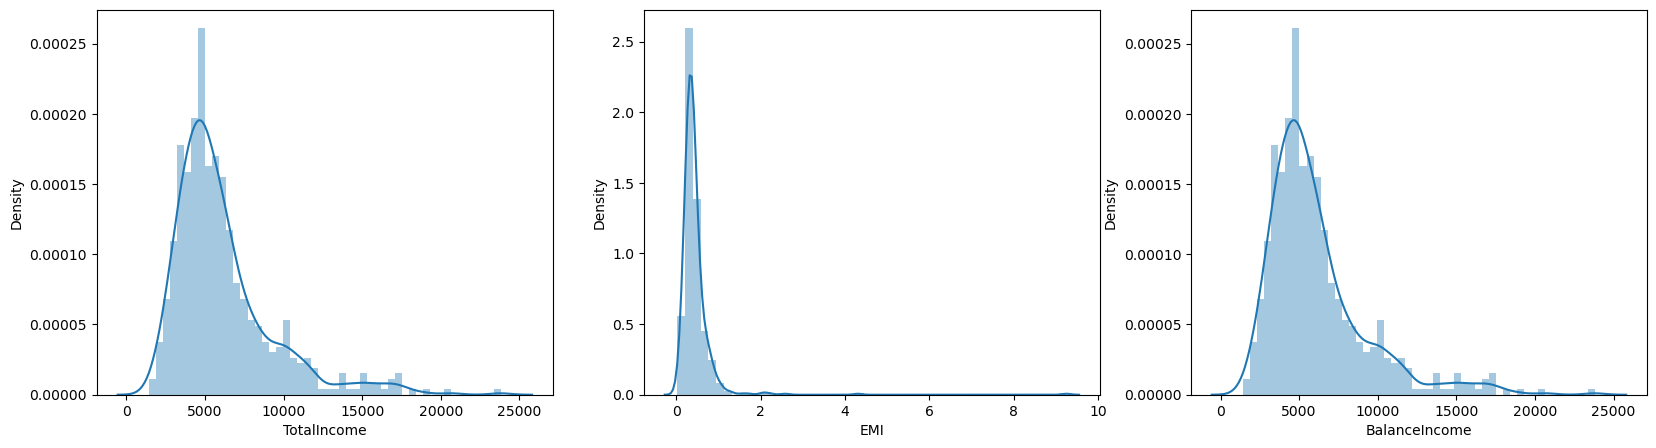

In [ ]:
tr['TotalIncome']=tr['ApplicantIncome']+tr['CoapplicantIncome']
tr['EMI']=tr['LoanAmount']/tr['Loan_Amount_Term']
tr['BalanceIncome']=tr['TotalIncome']-tr['EMI']

plt.figure(1,figsize=(20,5))
plt.subplot(1,3,1)
sns.distplot(tr['TotalIncome'])
plt.subplot(1,3,2)
sns.distplot(tr['EMI'])
plt.subplot(1,3,3)
sns.distplot(tr['BalanceIncome'])
plt.show()

In [ ]:
test['TotalIncome']=test['ApplicantIncome']+test['CoapplicantIncome']
test['EMI']=test['LoanAmount']/test['Loan_Amount_Term']
test['BalanceIncome']=test['TotalIncome']-test['EMI']

In [ ]:
tr.drop(['ApplicantIncome','CoapplicantIncome','Loan_Amount_Term','LoanAmount'],axis=1,inplace=True)
test.drop(['ApplicantIncome','CoapplicantIncome','Loan_Amount_Term','LoanAmount'],axis=1,inplace=True)


# Testing multiple models

In [ ]:
x=tr.drop('Loan_Status', axis=1)
y=tr['Loan_Status']

In [ ]:
def model(model_name,feature,target):
    i=1
    kf=StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
    for train_index,test_index in kf.split(x,y):
        print('{} of kfold {}'.format(i,kf.n_splits))
        xtr,xte= x.iloc[train_index],x.iloc[test_index]
        ytr,yte=y.iloc[train_index],y.iloc[test_index]
        
        model=model_name
        model.fit(xtr,ytr)
        pred=model.predict(xte)
        score=accuracy_score(yte,pred)
        print('Accuracy_score: ',score)
        i+=1
        pred=model.predict_proba(xte)[:,1]
    

### Logistic regression

In [ ]:
lr = LogisticRegression()
model(lr,x,y)
pred_test=lr.predict(test)
joblib.dump(lr, 'logistic_regression_model_new.joblib')

1 of kfold 5
Accuracy_score:  0.8181818181818182
2 of kfold 5
Accuracy_score:  0.8118393234672304
3 of kfold 5
Accuracy_score:  0.7124735729386892
4 of kfold 5
Accuracy_score:  0.8097251585623678
5 of kfold 5
Accuracy_score:  0.8305084745762712


/Users/cooperz/opt/anaconda3/envs/WebMining/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


['logistic_regression_model_new.joblib']

In [ ]:
submission['Loan_Status']=pred_test
submission['Loan_ID']=test_og['Loan_ID']

# submission['Loan_Status']=submission['Loan_Status'].map({1: 'Yes',0:'No'})
pd.DataFrame(submission).to_csv('LogisticRegression_new.csv')

### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
dt=DecisionTreeClassifier(max_depth=10)

In [ ]:
model(dt,x,y)

1 of kfold 5
Accuracy_score:  0.9386892177589852
2 of kfold 5
Accuracy_score:  0.9069767441860465
3 of kfold 5
Accuracy_score:  0.9027484143763214
4 of kfold 5
Accuracy_score:  0.8942917547568711
5 of kfold 5
Accuracy_score:  0.9152542372881356


In [ ]:
pred_test=dt.predict(test)
joblib.dump(dt, 'decision_tree_model_new.joblib')

['decision_tree_model_new.joblib']

In [ ]:
# submission['Loan_ID']=test_og['Loan_ID']
submission['Loan_Status']=pred_test
# submission['Gender']=test_og['Gender']
# submission['Race']=test_og['Race']

# submission['Loan_Status']=submission['Loan_Status'].map({1: 'Yes',0:'No'})
pd.DataFrame(submission).to_csv('DecisionTreeClassifier_new.csv')

### Random forest

In [ ]:
rfc=RandomForestClassifier(max_depth=5,n_estimators=21 ,random_state=1)
model(rfc,x,y)

1 of kfold 5
Accuracy_score:  0.8308668076109936
2 of kfold 5
Accuracy_score:  0.828752642706131
3 of kfold 5


Accuracy_score:  0.8202959830866807
4 of kfold 5
Accuracy_score:  0.8372093023255814
5 of kfold 5
Accuracy_score:  0.8432203389830508


In [ ]:
pred_test=rfc.predict(test)
joblib.dump(rfc, 'random_forest_model_new.joblib')


['random_forest_model_new.joblib']

In [ ]:
submission['Loan_Status']=pred_test

# submission['Loan_Status']=submission['Loan_Status'].map({1: 'Yes',0:'No'})
pd.DataFrame(submission, columns=['Loan_ID','Loan_Status','Gender', 'Race']).to_csv('RandomForestClassifier_new.csv')

# Feature Importance

<Axes: >

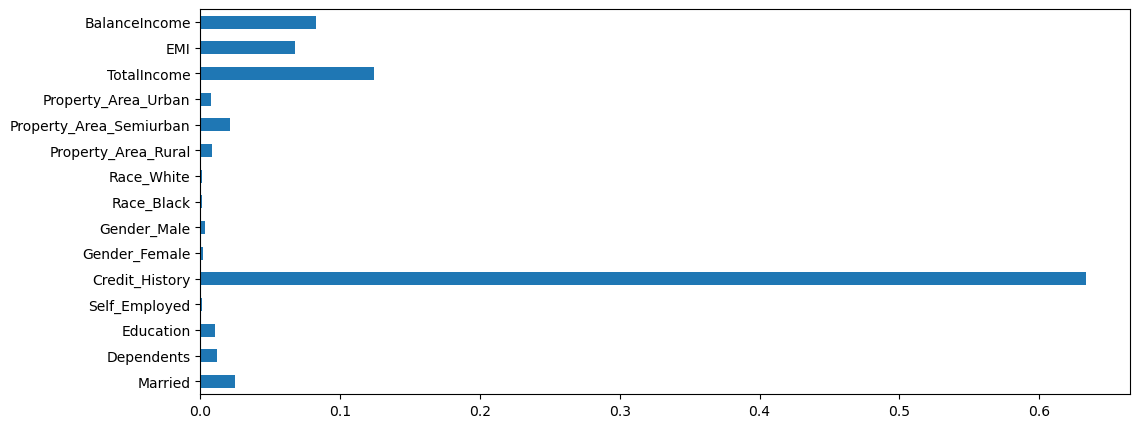

In [ ]:
importances=pd.Series(rfc.feature_importances_, index=x.columns)
importances.plot(kind='barh',figsize=(12,5))

# XGB CLassifier

In [ ]:
xgb=XGBClassifier()
model(xgb,x,y)
pred_test=xgb.predict(test)
joblib.dump(xgb, 'xgb_model_new.joblib')

1 of kfold 5
Accuracy_score:  1.0
2 of kfold 5
Accuracy_score:  0.9936575052854123
3 of kfold 5
Accuracy_score:  0.9936575052854123
4 of kfold 5
Accuracy_score:  1.0
5 of kfold 5
Accuracy_score:  1.0


['xgb_model_new.joblib']

In [ ]:
submission['Loan_Status']=pred_test

# submission['Loan_Status']=submission['Loan_Status'].map({1: 'Yes',0:'No'})
pd.DataFrame(submission, columns=['Loan_ID','Loan_Status','Gender', 'Race']).to_csv('XGBClassifier_new.csv')

### Evaluation of new models

In [ ]:
logistic = pd.read_csv('LogisticRegression_new.csv')
dt = pd.read_csv('DecisionTreeClassifier_new.csv')
rf = pd.read_csv('RandomForestClassifier_new.csv')
xgb = pd.read_csv('XGBClassifier_new.csv')

In [ ]:
races = logistic.Race.unique()
genders = logistic.Gender.unique()
races, genders

(array(['Black', 'White'], dtype=object),
 array(['Male', 'Female'], dtype=object))

In [ ]:
model_list_new = [Model('Logistic'), Model('DecisionTree'), Model('RandomForest'), Model('XGB')]

In [ ]:
show_bias(logistic, model_list_new[0])

Gender: 
Male 0.7643097643097643
Female 0.7285714285714285
Difference:  0.035738335738335736
Ratio:  0.9532410320956576

Race: 
Black 0.8263473053892215
White 0.7
Difference:  0.12634730538922156
Ratio:  0.8471014492753624


In [ ]:
show_bias(dt, model_list_new[1])

Gender: 
Male 0.7171717171717171
Female 0.6714285714285714
Difference:  0.04574314574314575
Ratio:  0.9362173038229376

Race: 
Black 0.7724550898203593
White 0.655
Difference:  0.11745508982035924
Ratio:  0.8479457364341085


In [ ]:
show_bias(rf, model_list_new[2])

Gender: 
Male 0.7676767676767676
Female 0.6857142857142857
Difference:  0.0819624819624819
Ratio:  0.893233082706767

Race: 
Black 0.8203592814371258
White 0.695
Difference:  0.12535928143712582
Ratio:  0.8471897810218977


In [ ]:
show_bias(xgb, model_list_new[3])

Gender: 
Male 0.7104377104377104
Female 0.6142857142857143
Difference:  0.0961519961519961
Ratio:  0.8646580907244414

Race: 
Black 0.7544910179640718
White 0.64
Difference:  0.1144910179640718
Ratio:  0.8482539682539684


#### Gender

In [ ]:
model_list_new = sorted(model_list_new, key=lambda x: x.gender_ratio)
for model in model_list_new:
    print(f'{model.name}, {model.gender_ratio:.4f}')

XGB, 0.8647
RandomForest, 0.8932
DecisionTree, 0.9362
Logistic, 0.9532


#### Race

In [ ]:
model_list_new = sorted(model_list_new, key=lambda x: x.race_ratio)
for model in model_list_new:
    print(f'{model.name}, {model.race_ratio:.4f}')

Logistic, 0.8471
RandomForest, 0.8472
DecisionTree, 0.8479
XGB, 0.8483


Here we use the average of `Race` and `Gender` demographic parity ratio as the bias score. The higher the score, the less biased the model is. 

In [ ]:
for model in model_list_new:
    model.fair_score = (model.gender_ratio + model.race_ratio) / 2

In [ ]:
print('Old Model List:\n')
model_list = sorted(model_list, key=lambda x: x.name)
for model in model_list:
    print(model)

print('avg fair score: ', sum([model.fair_score for model in model_list])/len(model_list))

print('\nNew Model List:\n')

model_list_new = sorted(model_list_new, key=lambda x: x.name)
for model in model_list_new:
    print(model)

print('avg fair score: ', sum([model.fair_score for model in model_list_new])/len(model_list_new))

Old Model List:

Model('DecisionTree', fair_score=0.8326049541475075)
Model('Logistic', fair_score=0.9427970616725864)
Model('RandomForest', fair_score=0.8392728604599735)
Model('XGB', fair_score=0.889234360410831)
avg fair score:  0.8759773091727245

New Model List:

Model('DecisionTree', fair_score=0.892081520128523)
Model('Logistic', fair_score=0.90017124068551)
Model('RandomForest', fair_score=0.8702114318643324)
Model('XGB', fair_score=0.856456029489205)
avg fair score:  0.8797300555418927


In [ ]:
print('Old Model List:\n')
model_list = sorted(model_list, key=lambda x: x.name)
print('Race: ')
for model in model_list:
    print(f'{model.name}: {model.race_ratio:.4f}') 

avg_race_score  = sum([model.race_ratio for model in model_list])/len(model_list)
print('avg race score: ', avg_race_score)

print('\nGender: ')
for model in model_list:
    print(f'{model.name}: {model.gender_ratio:.4f}')

avg_gender_score  = sum([model.gender_ratio for model in model_list])/len(model_list)
print('avg gender score: ', avg_gender_score)

### 

print('\nNew Model List:\n')

model_list_new = sorted(model_list_new, key=lambda x: x.name)
print('Race: ')
for model in model_list_new:
    print(f'{model.name}: {model.race_ratio:.4f}') 

avg_race_score  = sum([model.race_ratio for model in model_list_new])/len(model_list_new)
print('avg race score: ', avg_race_score)

print('\nGender: ')
for model in model_list_new:
    print(f'{model.name}: {model.gender_ratio:.4f}')

avg_gender_score  = sum([model.gender_ratio for model in model_list_new])/len(model_list)
print('avg gender score: ', avg_gender_score)

Old Model List:

Race: 
DecisionTree: 0.7850
Logistic: 0.9477
RandomForest: 0.8411
XGB: 0.8217
avg race score:  0.8489069647935469

Gender: 
DecisionTree: 0.8802
Logistic: 0.9379
RandomForest: 0.8374
XGB: 0.9567
avg gender score:  0.9030476535519023

New Model List:

Race: 
DecisionTree: 0.8479
Logistic: 0.8471
RandomForest: 0.8472
XGB: 0.8483
avg race score:  0.8476227337463342

Gender: 
DecisionTree: 0.9362
Logistic: 0.9532
RandomForest: 0.8932
XGB: 0.8647
avg gender score:  0.9118373773374508


Here we observe an improvement in `race`, thought the `gender` bias score dropped a bit.